In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *

In [2]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [3]:
client.restart()

Client Scheduler: tcp://131.204.27.88:8786 Dashboard: http://131.204.27.88:8787/status,Cluster Workers: 50 Cores: 100 Memory: 1000.00 GB


In [4]:
DATAROOT = "data"

In [5]:
level_01_masks = joblib.load(f"{DATAROOT}/predicted_v01.dict")

In [6]:
multi_class_images = {k: v for k, v in joblib.load(f"{DATAROOT}/multi_label_images.dict").items() if k in level_01_masks}
image_names = joblib.load(f"{DATAROOT}/image_names.pkl")
raw_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/raw_images.pkl"))).items() if k in level_01_masks}
original_images = {k: v for k, v in dict(zip(image_names, joblib.load(f"{DATAROOT}/images.pkl"))).items() if k in level_01_masks}

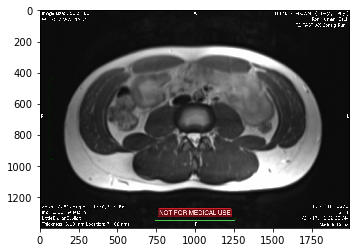

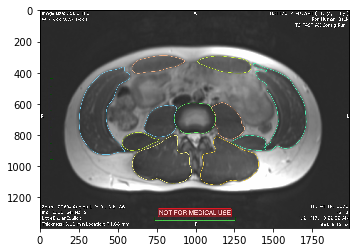

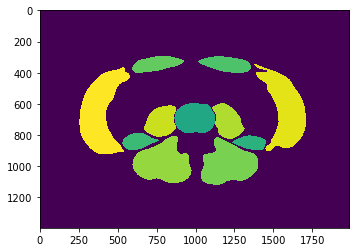

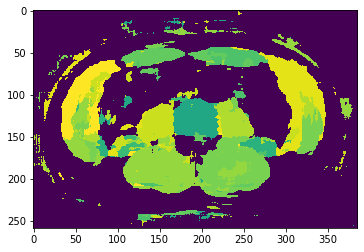

In [7]:
label = np.random.choice(list(level_01_masks.keys()))
plt.imshow(raw_images[label])
plt.show()
plt.imshow(original_images[label])
plt.show()
plt.imshow(multi_class_images[label])
plt.show()
plt.imshow(level_01_masks[label])

In [8]:
assert len(raw_images) == len(original_images)
assert len(raw_images) == len(level_01_masks)

In [9]:
x = sorted([(k, v) for k, v in original_images.items()], key=lambda x: x[0])
y = sorted([(k, v) for k, v in multi_class_images.items()], key=lambda x: x[0])
mask = sorted([(k, v) for k, v in level_01_masks.items()], key=lambda x: x[0])

In [10]:
level_01_masks.keys() - multi_class_images.keys(), multi_class_images.keys() - level_01_masks.keys()

(set(), set())

In [11]:
def clean_image(kv, shape):
    k, img = kv
    if len(img.shape) > 2:
        img = img.mean(axis=2).astype('uint8')
    cleaned_hist_img = cv2.equalizeHist(img)
    gaussian_kernel_size = tuple(((x//40)//2)*2+1 for x in cleaned_hist_img.shape)
    blurred_img = cv2.GaussianBlur(cleaned_hist_img, gaussian_kernel_size, 1)
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = zoom(blurred_img, zoom_rate)
    return k, (out-out.mean())/out.std()

def clean_mask(kv, shape):
    k, img = kv
    if len(img.shape) > 2:
        img = img.sum(axis=2).astype('uint8')
    zoom_rate = tuple(x/y for x,y in zip(shape, img.shape)) if isinstance(shape, tuple) \
                else shape if shape < 1 else shape/img.shape[0]
    out = []
    for c in sorted(np.unique(img))[1:]:
        segment = (zoom((img==c)*255, zoom_rate)>0)*c
        out.append(segment)
    return k, np.max(np.array(out), axis=0)

#def get_image_positional_values(img):
#    w, h, *_ = img.shape
#    x, y = np.meshgrid(np.arange(w)/w, np.arange(h)/h)
#    return np.vstack([x.reshape(-1), y.reshape(-1)]).T, img.reshape(-1)



In [12]:
x_b = bag.from_sequence(x)
y_b = bag.from_sequence(y)
m_b = bag.from_sequence(mask)

In [13]:
cleaned_x = x_b.map(clean_image, shape=300)#.compute()#[delayed(clean_image)(x, 200) for x in imgTr.values()]
cleaned_y = y_b.map(clean_mask, shape=300)#.compute()#[delayed(clean_image)(x, 200) for x in imgTr.values()]

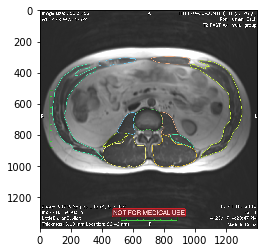

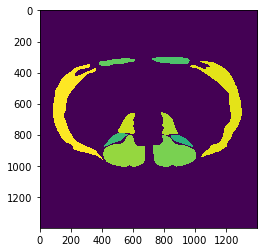

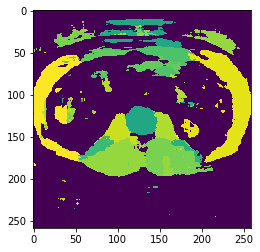

In [14]:
n = np.random.randint(len(mask))
plt.imshow(x[n][1])
plt.show()
plt.imshow(y[n][1])
plt.show()
plt.imshow(mask[n][1])

In [15]:
def sample(kvx, kvy, kvmask, neighSize, step):
    x = kvx[1]
    y = kvy[1]
    mask = kvmask[1]
    m1 = neighSize//2
    m2 = neighSize-m1
    w, h, *_ = x.shape
    x_out = []
    y_out = []
    for i in range(m1, w-m2, step):
        for j in range(m1, h-m2, step):
            x_out.append(x[i-m1:i+m2, j-m1:j+m2])
            y_out.append(y[i, j])
    x = np.array(x_out)
    y = np.array(y_out)
    return x.reshape(*x.shape, 1), y.reshape(*y.shape, 1)

In [16]:
XY_bag = bag.map(sample, cleaned_x, cleaned_y, m_b, 41, 1)

In [17]:
XY = XY_bag.take(1)

In [18]:
X = np.concatenate([x[0] for x in XY])
Y = np.concatenate([x[1] for x in XY])
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y).toarray()

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, 
	horizontal_flip=True, fill_mode="nearest")

In [21]:
# keras important imports:
# import the necessary packages
from keras.models import Sequential
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split       

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import losses

ModuleNotFoundError: No module named 'keras'

In [37]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses

In [38]:
# Keras simple deep model:
def build_v02(width, height, depth, init="he_normal"):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using "channels first", update the input shape
    # and channels dimension
    # our first CONV layer will learn a total of 16 filters, each
    # Of which are 7x7 -- we'll then apply 2x2 strides to reduce
    # the spatial dimensions of the volume
    #model.add(Conv2D(32, (10, 10), strides=(1, 1), padding="same",
    #    kernel_initializer=init,# kernel_regularizer=reg,
    #    input_shape=inputShape))

    # here we stack two CONV layers on top of each other where
    # each layerswill learn a total of 32 (3x3) filters
    model.add(Conv2D(32, (10, 10), padding="valid",
        kernel_initializer=init, #kernel_regularizer=reg)
                    ))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv2D(32, (5, 5), strides=(1, 1), padding="valid",
    #    kernel_initializer=init, #kernel_regularizer=reg)
    #                ))
    #model.add(Activation("relu"))
    #model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.25))
    # stack two more CONV layers, keeping the size of each filter
    # as 3x3 but increasing to 64 total learned filters
    #model.add(Conv2D(64, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    #model.add(Dropout(0.25))
#
    ## increase the number of filters again, this time to 128
    #model.add(Conv2D(128, (3, 3), padding="same",
    #    kernel_initializer=init, kernel_regularizer=reg))
    #model.add(Activation("relu"))
    ##model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(10, (3, 3), strides=(1, 1), padding="valid",
        kernel_initializer=init,  #kernel_regularizer=reg
                    )
             )
    model.add(Activation("relu"))
    #model.add(Conv2D(1, (3, 3), strides=(1, 1), padding="same",
    #    kernel_initializer=init, #kernel_regularizer=reg)
    #                ))
    #model.add(Activation("relu"))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(12))
    #model.add(Dense(1))
    model.add(Activation("sigmoid"))
    #model.add(BatchNormalization(axis=chanDim))
    return model

In [42]:
from tensorflow.keras.models import load_model
model = build_v02(20, 20, depth=1)
#model = load_model("data/04_muti_class_cnn_v03.model")
opt = Adam(lr=1e-4)#, decay=1e-4 / epochs)
model.compile(loss=losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
#model.save("data/model_04_muti_class_cnn_v03.model")

In [43]:
#BS = 64
#generator = aug.flow(X, Y, batch_size=BS)
X = (X-X.mean())/X.std()

In [44]:
model.fit(X, Y, epochs=10, shuffle=True, batch_size=1024)
#model.fit_generator(generator,
#	steps_per_epoch=len(X) // BS, epochs=EPOCHS)

Train on 67081 samples
Epoch 1/10
67081/67081 [==============================] - 86s 1ms/sample - loss: 1.1210 - acc: 0.8918
Epoch 2/10
67081/67081 [==============================] - 111s 2ms/sample - loss: 0.8596 - acc: 0.9061
Epoch 3/10
67081/67081 [==============================] - 131s 2ms/sample - loss: 0.8111 - acc: 0.9061
Epoch 4/10
46080/67081 [===================>..........] - ETA: 40s - loss: 0.7862 - acc: 0.9055

KeyboardInterrupt: 

In [ ]:
EPOCHS = 10
model.fit(X, Y, epochs=EPOCHS)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


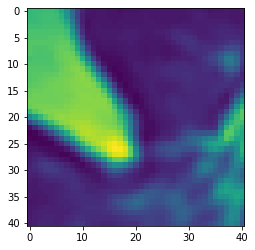

In [69]:
n = np.random.randint(len(X))
plt.imshow(X[n].reshape(41, 41))
print(Y[n])

In [69]:
from itertools import repeat

In [75]:
pred_v01 = []
for x, y in zip(cleaned_images_bag, cleaned_masks_bag):
    print(x.shape)
    w, h, *_ = x.shape
    x1, y1 = sample(x, y, 41, 1)
    pred_v01.append(encoder.inverse_transform(model.predict(x1)).reshape(w-41, h-41))

(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 427)
(300, 320)
(300, 300)
(300, 427)
(300, 427)
(300, 427)
(300, 427)
(300, 427)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 430)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 427)
(300, 426)
(300, 300)
(300, 427)
(300, 300)
(300, 427)
(300, 427)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 427)
(300, 300)
(300, 300)
(300, 300)
(300, 427)
(300, 300)
(300, 300)
(300, 426)
(300, 300)
(300, 427)
(300, 427)
(300, 427)

In [1]:
#joblib.dump(dict(zip(imgTr.keys(), pred_v01)), "data/predicted_v01.dict")
#model.save("data/04_muti_class_cnn_v03.model")

# Step 2